<h1>Jebish Purbey</h1>
<h3>Task 3 - RealTime Face Mask Detection</h3>
<Strong>Implemented using Tensorflow Keras and Open CV</Strong>

First of all, We import all the required libraries and frameworks. We are using Tensorflow MobileNetV2 for mask detection and pretrained Res10 face detection model.

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import tensorflow.keras.layers as tfl

%matplotlib inline

For the data, we are using dataset "Covid-19-PIS Dataset" provided by Roboflow. The dataset contains 690 face images with mask, and 686 face images without mask. Because, we only need to detect whether mask is worn or not, we can use binary classification to detect both presence and absence of mask. Here, 1 means presence of mask and 0 means absence of mask.

In [2]:
directory='./dataset/train/'
BATCH_SIZE=32
IMG_SIZE=(224,224)
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(directory=directory,batch_size=BATCH_SIZE,class_names=['without mask','with mask'],image_size=IMG_SIZE,shuffle=True,seed=1,validation_split=0.2,subset='training')
validation_dataset=tf.keras.preprocessing.image_dataset_from_directory(directory=directory,batch_size=BATCH_SIZE,class_names=['without mask','with mask'],image_size=IMG_SIZE,shuffle=True,seed=1,validation_split=0.2,subset='validation')

Found 1279 files belonging to 2 classes.
Using 1024 files for training.
Found 1279 files belonging to 2 classes.
Using 255 files for validation.


Let's see some data with their labels to get an idea of what we are working with.

['without mask', 'with mask']


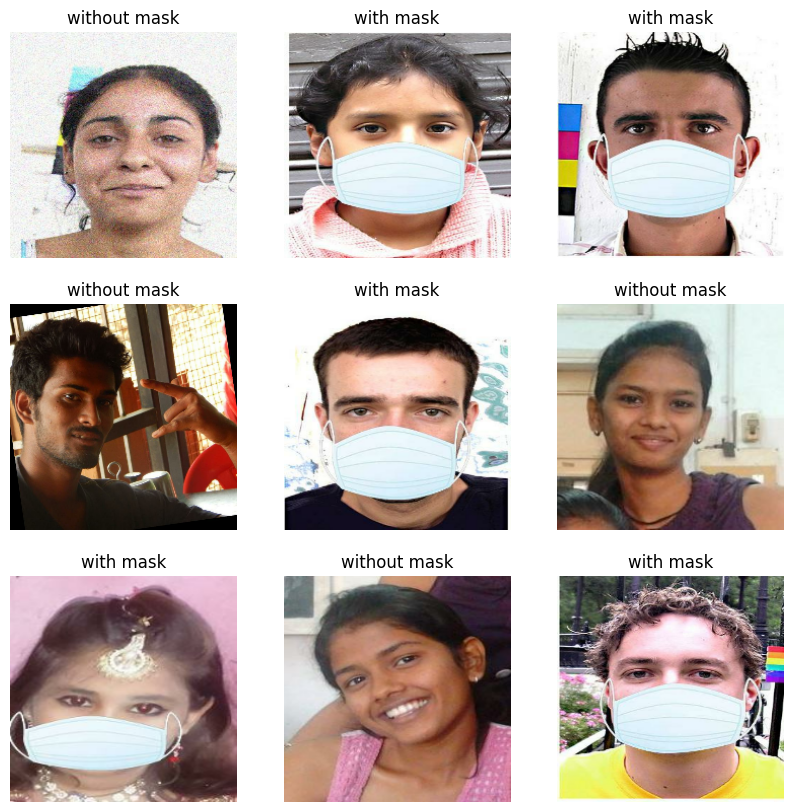

In [3]:
class_names=train_dataset.class_names
print(class_names)
plt.figure(figsize=(10,10))
for (images,labels) in train_dataset.take(2):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i].numpy()])
        
        plt.axis('off')

In order to not have bottleneck while fetching data, we will use prefetching with buffer size as Autotune. This means, tensorflow itself detects the best buffer size.

In [4]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)

Let's use a small data augmentation, with just rotation and horizontal flip. We will create the augmenter as a sequential model, which we will use during training.

In [5]:
def data_augmenter():
    data_augmentation=tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))

    return data_augmentation
data_augmentation=data_augmenter()

In [6]:
train_dataset.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Because we are using MobileNet for our mask detection model, we need to convert our features into the acceptable format of mobilenet. MobileNet uses data range from [-1,1], so our data needs to be normalized within the range. We use the preprocess_input object to do the required conversion.

In [7]:
preprocess_input=tf.keras.applications.mobilenet_v2.preprocess_input

<strong>Defining the model</strong>
MobileNet requires input shape as (h_x,w_x,3) where h_x=height, w_x=width and 3=number of channels. We define input shape as (IMG_SIZE)+(3,). IMG_SIZE = (224,224), the operation makes input_shape=(224,224,3). Because we are using Keras, we create a placeholder input with keras.input of required shape. The input is then fed to data augmentation and preprocessing. After that, the resulting data is fed to base model which is MobileNet V2. The output from base model is flatten using gloval average pooling. We use dropout to decrease overfitting. Because we can use 1 or 0 for output, we only need one neuron for our detection, which we will keep linear activated, as we will use logits for loss calculation. The tf.keras.Model function is used as functional API to create the model pipeline.

In [8]:
input_shape=IMG_SIZE+(3,)
base_model=tf.keras.applications.MobileNetV2(input_shape=input_shape,include_top=False,weights='imagenet')
base_model.trainable=False
def mask_model(image_shape=IMG_SIZE,data_augmentation=data_augmenter()):
    input_shape=image_shape+(3,)
    inputs=tf.keras.Input(shape=input_shape)
    x=data_augmentation(inputs)
    x=preprocess_input(x)
    x=base_model(x,training=False)
    x=tfl.GlobalAveragePooling2D()(x)
    x=tfl.Dropout(0.2)(x)
    prediction_layer=tfl.Dense(1)
    outputs=prediction_layer(x)
    model=tf.keras.Model(inputs,outputs)
    return model

In [9]:
mask_detect=mask_model(IMG_SIZE,data_augmentation)

For compiling the model, we need to define our optimizer which will be Adam here, loss function (binary cross entropy or logistic regression loss) and metrics that will be used for judging the model.

In [10]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

mask_detect.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

Now, it's time to train the model. In order to track the records, let's use a variable "history" to return the datas from training.

In [11]:
initial_epoch=5
history=mask_detect.fit(train_dataset,validation_data=validation_dataset,epochs=initial_epoch)

Epoch 1/5


32/32 [==============================] - 27s 753ms/step - loss: 0.2707 - accuracy: 0.8779 - val_loss: 0.0111 - val_accuracy: 0.9922
Epoch 2/5
32/32 [==============================] - 23s 708ms/step - loss: 0.0334 - accuracy: 0.9854 - val_loss: 0.0088 - val_accuracy: 0.9961
Epoch 3/5
32/32 [==============================] - 22s 692ms/step - loss: 0.0241 - accuracy: 0.9893 - val_loss: 0.0177 - val_accuracy: 0.9922
Epoch 4/5
32/32 [==============================] - 18s 573ms/step - loss: 0.0192 - accuracy: 0.9932 - val_loss: 0.0112 - val_accuracy: 0.9961
Epoch 5/5
32/32 [==============================] - 21s 669ms/step - loss: 0.0141 - accuracy: 0.9951 - val_loss: 0.0169 - val_accuracy: 0.9922


We can see that the loss is very low and accuracy is really high. Let's check the graphs to see if there's overfitting.

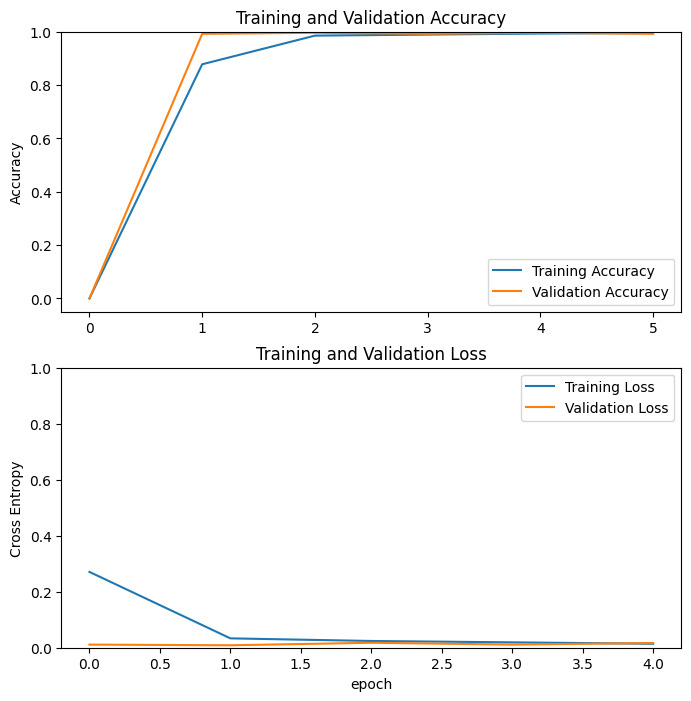

In [12]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


We see that the model performs suprisingly well even without fine tuning. This might be because we are only doing binary classification, and that too on images that can be separated really easily. Still, let's fine tune the model a bit.

In [13]:
base_model.trainable=True
at_point=126
for layer in base_model.layers[:at_point]:
    layer.trainable=False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [14]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

mask_detect.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [15]:
total_epoch=10
history_fine=mask_detect.fit(train_dataset,validation_data=validation_dataset,
                           epochs=total_epoch,initial_epoch=history.epoch[-1])

Epoch 5/10


32/32 [==============================] - 28s 744ms/step - loss: 0.0415 - accuracy: 0.9844 - val_loss: 0.0047 - val_accuracy: 0.9961
Epoch 6/10
32/32 [==============================] - 22s 685ms/step - loss: 0.0152 - accuracy: 0.9961 - val_loss: 0.0170 - val_accuracy: 0.9922
Epoch 7/10
32/32 [==============================] - 22s 672ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 0.9922
Epoch 8/10
32/32 [==============================] - 22s 673ms/step - loss: 0.0058 - accuracy: 0.9971 - val_loss: 9.4286e-04 - val_accuracy: 1.0000
Epoch 9/10
32/32 [==============================] - 21s 668ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.0229 - val_accuracy: 0.9922
Epoch 10/10
32/32 [==============================] - 22s 681ms/step - loss: 0.0100 - accuracy: 0.9990 - val_loss: 2.7891e-04 - val_accuracy: 1.0000


In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Accuracy')

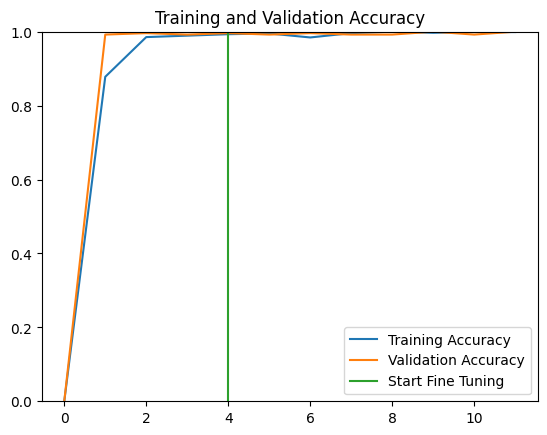

In [17]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epoch-1,initial_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

After fine tuning, the accuracy and loss of the model is good for using. Now, let's save the model, so that we can use it without training in future.

In [18]:
mask_detect.save("mask_detect.keras")

Let's use the saved model from hereon for detecting masks.

In [19]:
mask_net=tf.keras.models.load_model('mask_detect.keras')
mask_net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

Now, that we have created the model for mask detection, let's load the pretrained res10 model using opencv dnn for detecting faces from image.

In [20]:
prototxtPath='face_detector/deploy.prototxt'
weightsPath='face_detector/res10_300x300_ssd_iter_140000.caffemodel'
net=cv2.dnn.readNet(prototxtPath,weightsPath)

Before creating a realtime detector, let's try to implement our model in a still image first.

In [21]:
image=cv2.imread('test2.jpg')
original_image=image.copy()

We use opencv blobFromImage for preprocessing the image before feeding to res10.

In [22]:
(h,w,n_C)=image.shape
blob=cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177.0,123.0))

We feed the blob into our face detection network "net" and then get the detection result in "detections".

In [23]:
net.setInput(blob)
detections=net.forward()

Running a loop on all detections obtained, we check if the probability that the detection is face crosses a threshold or not. After that we obtain the location coordinates for drawing the bounding box and use the coordinates to get a face from image as well. The face is then fed to the mask detector module to obtain the prediction whether the face has mask or not.

In [24]:
for i in range(0,detections.shape[2]):
    probability=detections[0,0,i,2]
    if probability>=0.5:
        
        box=detections[0,0,i,3:7]*np.array([w,h,w,h])
        (startX,startY,endX,endY)=box.astype("int")

        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        face=image[startY:endY, startX:endX]
        face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        face=cv2.resize(face,(224,224))
        face=tf.keras.preprocessing.image.img_to_array(face)
        face=np.expand_dims(face,axis=0)
        
        y_hat=mask_net.predict(face)
        print(y_hat)
        prediction=tf.keras.activations.sigmoid(y_hat)
        print(prediction[0,0].numpy())
        label='Mask' if prediction>=0.5 else "No_Mask"
        color=(0,255,0) if label=='Mask' else (0,0,255)

        label="{}: {:.2f}%".format(label,prediction[0,0]*100)

        cv2.putText(image,label,(startX,startY-10),2,0.45,color,2)
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)
    
    cv2.imshow('Output',image)
    key=cv2.waitKey(0) & 0xFF

    if key==27:
        break
        

cv2.destroyAllWindows()


1/1 [==============================] - 1s 882ms/step
[[-17.041962]]
3.9698133e-08


<h4>Real Time Face Mask Detection</h4>
Now, that we have seen that the model works on still images, it's time to implement the realtime detection. For that we shall use opencv video capture to capture frames for video and then repeat the process as above.

In [25]:
def mask_video(frame,net,mask_detect):
    (h,w)=frame.shape[:2]
    blob=cv2.dnn.blobFromImage(frame,1.0,(300,300),(104.0,177.0,123.0))

    net.setInput(blob)
    detections=net.forward()

    faces=[]
    locs=[]
    preds=[]

    for i in range(0,detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>=0.5:
            box=detections[0,0,i,3:7]*np.array([w,h,w,h])
            (startX,startY,endX,endY)=box.astype("int")

            (startX,startY)=(max(0,startX),max(0,startY))
            (endX,endY)=(min(w-1,endX),min(h-1,endY))

            face=frame[startY:endY, startX:endX]
            face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
            face=cv2.resize(face,IMG_SIZE)
            face=tf.keras.preprocessing.image.img_to_array(face)

            faces.append(face)
            locs.append((startX,startY,endX,endY))

    if len(faces)>0:

        faces=np.array(faces,dtype='float32')
        preds=mask_net.predict(faces)
    return (locs,preds)

Press "ESC" to exit the openCV window.

In [27]:
feed=cv2.VideoCapture(0)
if not feed.isOpened():
    raise IOError("Cannot open Video feed")

while True:
    ret,frame=feed.read()
    (locs,preds)=mask_video(frame,net=net,mask_detect=mask_detect)

    for (box,pred) in zip(locs,preds):
        (startX,startY,endX,endY)=box
        pred=tf.nn.sigmoid(pred)
        label="Mask" if pred>=0.5 else "No Mask"
        color=(0,255,0) if label=="Mask" else (0,0,255)

        text="{}: {:.2f}%".format(label,pred[0]*100)

        cv2.putText(frame,text,(startX,startY-10),2,0.45,color,2)
        cv2.rectangle(frame,(startX,startY),(endX,endY),color,2)

    cv2.imshow("Feed",frame)
    key=cv2.waitKey(1) & 0xFF

    if key==27:
        break

feed.release()
cv2.destroyAllWindows()

    

1/1 [==============================] - 0s 61ms/step


<h2>The END</h2>